Found 220 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Stage 1: Training only top layers for VGG16...
Epoch 1/5
6/6 [==============================] - 21s 2s/step - loss: 0.7348 - accuracy: 0.5990 - val_loss: 0.7025 - val_accuracy: 0.6250
Epoch 2/5
6/6 [==============================] - 19s 4s/step - loss: 0.7305 - accuracy: 0.5638 - val_loss: 0.7505 - val_accuracy: 0.3750
Epoch 3/5
6/6 [==============================] - 12s 2s/step - loss: 0.6606 - accuracy: 0.5904 - val_loss: 0.5992 - val_accuracy: 0.6875
Epoch 4/5
6/6 [==============================] - 12s 2s/step - loss: 0.6216 - accuracy: 0.7500 - val_loss: 0.6016 - val_accuracy: 0.8281
Epoch 5/5
6/6 [==============================] - 11s 2s/step - loss: 0.5984 - accuracy: 0.7394 - val_loss: 0.5640 - val_accuracy: 0.8125

Layers being fine-tuned:
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True

Stage 2: Fine-tuning top layers for VGG16...
Epoch 1/10
6/6 [========================

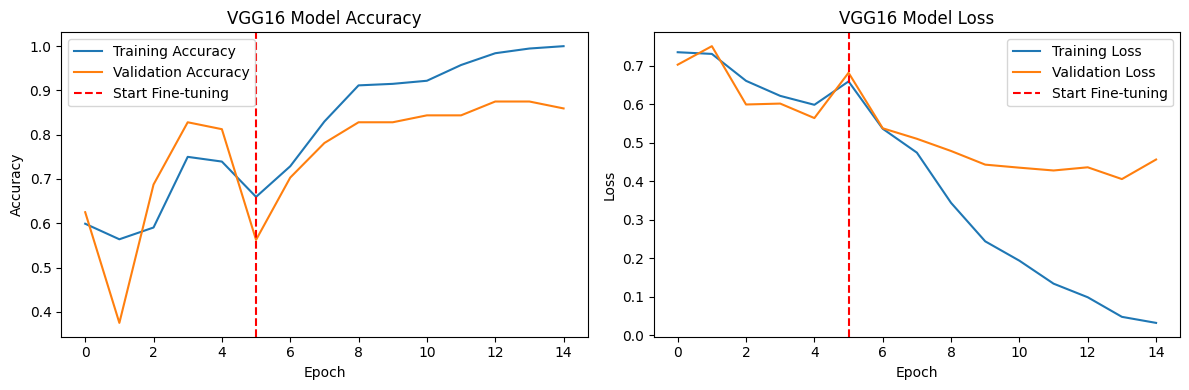

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# 設定參數
img_width, img_height = 224, 224
batch_size = 32
train_dir = 'train'
test_dir = 'test'

# 資料載入器
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# 第一階段：凍結所有預訓練層，只訓練頂部分類層
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# 凍結所有層
for layer in base_model.layers:
    layer.trainable = False
    
# 添加自定義分類層
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 第一階段編譯
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 確保顯示所有訓練進度
verbose = 1  # 1 = 進度條, 2 = 每個epoch一行

print("Stage 1: Training only top layers for VGG16...")
# 第一階段訓練
history_1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    verbose=verbose
)

# 第二階段：解凍部分頂層進行微調
# 解凍最後4個卷積層（VGG16頂部的block5）
for layer in base_model.layers[-4:]:
    layer.trainable = True

# 顯示哪些層被解凍
print("\nLayers being fine-tuned:")
for layer in base_model.layers[-4:]:
    print(f"{layer.name}: {layer.trainable}")

# 第二階段編譯（使用更小的學習率）
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # 使用更小的學習率
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nStage 2: Fine-tuning top layers for VGG16...")
# 第二階段訓練（微調）
history_2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    verbose=verbose
)

# 評估最終模型
eval_result = model.evaluate(test_generator)
print(f"\nVGG16 Final Results - Test Loss: {eval_result[0]:.4f}, Test Accuracy: {eval_result[1]:.4f}")

# 合併兩階段的訓練歷史
combined_history = {}
for key in history_1.history.keys():
    combined_history[key] = history_1.history[key] + history_2.history[key]

# 保存模型
model.save('vgg16_gender_classifier.h5')
print("Model saved as vgg16_gender_classifier.h5")

# 繪製訓練歷史
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Training Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=5, color='r', linestyle='--', label='Start Fine-tuning')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.axvline(x=5, color='r', linestyle='--', label='Start Fine-tuning')
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('vgg16_training_history.png')
plt.show()